In [1]:
import math
import torch
from torch import nn

In [2]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as torch_data
from skimage.transform import resize

In [3]:
from torchvision.transforms import ToTensor

In [4]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_source_test'
RANDOM_STATE = 42

In [5]:
def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)

In [6]:
class SRGANMRIDataLoader(torch_data.Dataset):
    def __init__(self, path_to_data, seed=None):
        super().__init__()

        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('.npy')]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        slice = npy_load(self.images[idx])
        slice_r = resize(slice[0], (320, 320), preserve_range=True)
        slice_r = np.expand_dims(slice_r, axis=(2))

        resized = self.sample_resize(slice)
        resized = resized.squeeze(axis=2)

        resized_new = np.dstack((resized,resized,resized))
        resized_tensor = ToTensor()(resized_new).unsqueeze(0)
        
        return resized_tensor
        
    def sample_resize(self, slice):
        slice_res = resize(slice[0], (80, 80), preserve_range=True)
        slice_res = np.expand_dims(slice_res, axis=(2))
#         print(slice.shape, slice_res.shape)
        return slice_res

In [7]:
train_loader = SRGANMRIDataLoader(PATH_TO_SOURCE_TEST, seed=RANDOM_STATE)

In [8]:
resized_tensor = train_loader.__getitem__

In [9]:
len(train_loader)

14697

In [1]:
import math

import torch.nn.functional as F
from torch import nn


class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (F.tanh(block8) + 1) / 2


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x


In [347]:
main_model = Generator(scale_factor = 4)
main_model.load_state_dict(torch.load('Fast-SRGAN/netG_epoch_4_100.pth'))

<All keys matched successfully>

In [358]:
main_model.eval()
out = main_model(train_loader.__getitem__(0))

before (80, 80)
(80, 80, 3)
torch.Size([1, 3, 80, 80])


In [359]:
def calculate_spec(fft):
    spectrum = 20*np.log(np.abs(fft) + 1e-9)
    return spectrum

In [360]:
out.shape

torch.Size([1, 3, 320, 320])

In [361]:
main_model.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (block2): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block3): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (prelu): PReLU(num_parameters=1)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block4): ResidualBlock(
    (conv1)

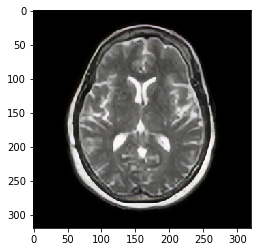

In [362]:
npimg = out[0].detach().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')